<a href="https://colab.research.google.com/github/Ware-Hard-or-Soft/Data-Mining-and-Recommendation-Systems/blob/main/Deep_Reinforcement_Learning_for_AMS_Circuit_Design_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Reinforcement Learning (DQN) for AMS Circuit Design
By David Zheng

In [1]:
!pip install PySpice==1.3.2
!sudo apt-get install ngspice
!ngspice -v
!sudo apt install libngspice0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ngspice is already the newest version (36+ds-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
******
** ngspice-36 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2020, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Mon Mar 11 21:44:53 UTC 2024
******
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libngspice0 is already the newest version (36+ds-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


In [12]:
import subprocess
def generate_Opamp_Netlist(r1, r2, c1):
    """
    Generates the SPICE netlist for an OPAMP circuit with an included OPAMP subcircuit.

    Args:
        r1: Resistor R1 value
        r2: Resistor R2 value
        c1: Capacitor C1 value

    Returns:
        The filename of the generated SPICE netlist.
    """
    netlist = f"""
* OPAMP Circuit with AC input
V1 1 0 AC 1
R1 1 3 {r1}
R2 3 0 {r2}
C1 3 0 {c1}
X1 3 0 4 OPAMP

* OPAMP subcircuit (simplified model)
.subckt OPAMP 1 2 3
E1 3 0 1 2 100k
.ends OPAMP

* AC analysis
.ac dec 10 1k 100Meg

* Output commands
.print ac V(3) V(1)

.end
"""
    filename = "opamp_circuit.sp"
    with open(filename, 'w') as file:
        file.write(netlist)
    return filename
def run_ngspice(netlist_file):
    """
    Runs the NgSpice simulation for the given netlist file.

    Args:
        netlist_file: The filename of the SPICE netlist.

    Returns:
        The output from the NgSpice simulation as a string.
    """
    command = f"ngspice -b {netlist_file}"
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    if result.returncode != 0:
        raise RuntimeError(f"NgSpice error: {result.stderr.decode()}")

    return result.stdout.decode()
def parse_simulation_output(output):
    """
    Parses the output from the NgSpice simulation to extract the gain and bandwidth.

    Args:
        output: The raw output from NgSpice.

    Returns:
        gain: The gain of the circuit.
        bandwidth: The bandwidth of the circuit.
    """
    # This is a placeholder function. You can customize it to extract specific information from the simulation output.
    # In a real simulation, you'd parse the gain and bandwidth from the AC analysis output.
    gain = 10  # Placeholder value
    bandwidth = 1e6  # Placeholder value

    return gain, bandwidth


In [13]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# Generate SPICE netlist with new OPAMP subcircuit
netlistFile = generate_Opamp_Netlist(r1=1e3, r2=1e3, c1=1e-9)

# Run the NgSpice simulation
output = run_ngspice(netlistFile)

# Check the output
print(output)


No compatibility mode selected!


Circuit: 

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 51
                                        
                                        AC Analysis  Wed Oct 23 05:52:46  2024
--------------------------------------------------------------------------------
Index   frequency       v(3)                            
--------------------------------------------------------------------------------
0	1.000000e+03	4.999951e-01,	-1.57078e-03	
1	1.258925e+03	4.999922e-01,	-1.97748e-03	
2	1.584893e+03	4.999876e-01,	-2.48948e-03	
3	1.995262e+03	4.999804e-01,	-3.13403e-03	
4	2.511886e+03	4.999689e-01,	-3.94542e-03	
5	3.162278e+03	4.999507e-01,	-4.96680e-03	
6	3.981072e+03	4.999218e-01,	-6.25247e-03	
7	5.011872e+03	4.998761e-01,	-7.87068e-03	
8	6.309573e+03	4.998036e-01,	-9.90716e-03	
9	7.943282e+03	4.996888e-01,	-1.24695e-02	
10	1.000000e+04	4.995070e-01,	-1.56925e-02	
11	1.258925e+04	4.992191e-01,	-1.97443e-02	
12	1.584893e+04	4

In [16]:
!pip install gymnasium
!pip install stable-baselines3

In [24]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from stable_baselines3 import DQN
class OPAMPEnvironment(gym.Env):
    def __init__(self):
        super(OPAMPEnvironment, self).__init__()

        # Define action space: 6 discrete actions (increase/decrease R1, R2, C1)
        self.action_space = spaces.Discrete(6)

        # Define observation space: R1, R2, C1 values
        self.observation_space = spaces.Box(low=np.array([1e2, 1e2, 1e-12]),
                                            high=np.array([1e6, 1e6, 1e-6]),
                                            dtype=np.float32)

        self.state = None
        self.steps = 0
        self.max_steps = 50

    def reset(self, seed=None, options=None):
        # Reset the environment to the initial state
        self.state = np.array([1e3, 1e3, 1e-9], dtype=np.float32)  # Explicitly set dtype to float32
        self.steps = 0
        return self.state, {}

    def step(self, action):
        # Apply the action to modify the state (R1, R2, C1)
        r1, r2, c1 = self.state
        if action == 0:
            r1 += 10  # Adjust the increments for finer control
        elif action == 1:
            r1 -= 10
        elif action == 2:
            r2 += 10
        elif action == 3:
            r2 -= 10
        elif action == 4:
            c1 *= 1.01  # Smaller scaling for finer control
        elif action == 5:
            c1 *= 0.95

        # Ensure parameters remain within valid bounds
        r1 = np.clip(r1, 1e2, 1e6)
        r2 = np.clip(r2, 1e2, 1e6)
        c1 = np.clip(c1, 1e-12, 1e-6)

        self.state = np.array([r1, r2, c1], dtype=np.float32) # Explicitly set dtype to float32

        # Generate SPICE netlist and run simulation
        netlist_file = generate_Opamp_Netlist(r1, r2, c1)
        output = run_ngspice(netlist_file)
        gain, bandwidth = parse_simulation_output(output)

        # Reward is based on gain and bandwidth
        target_gain = 800
        target_bandwidth = 1e6
        gain_penalty = abs(target_gain - gain)
        bandwidth_penalty = abs(target_bandwidth - bandwidth)

        reward = -(gain_penalty * 0.01 + bandwidth_penalty * 0.001)

        self.steps += 1
        # done was previously a boolean, now split into terminated and truncated
        terminated = self.steps >= self.max_steps  # Episode ends if max_steps reached
        truncated = False  # No truncation condition in this environment

        # return self.state, reward, done, {}  # Original line with 4 return values
        return self.state, reward, terminated, truncated, {}  # Updated line with 5 return values np.float32

    def render(self):
        pass  # Not needed for

In [27]:
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class LossCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LossCallback, self).__init__(verbose)
        self.losses = []

    def _on_step(self) -> bool:
        # Access the loss value
        if 'loss' in self.model.ep_info_buffer:
            loss = self.model.ep_info_buffer['loss']
            self.losses.append(loss)
        return True

# Create the environment and DQN model
env = OPAMPEnvironment()  # Assuming you have defined this environment
model = DQN('MlpPolicy', env, verbose=1)

# Train the model and use the custom callback
loss_callback = LossCallback()
model.learn(total_timesteps=50000, callback=loss_callback)

# Access the loss values from the callback
losses = loss_callback.losses

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | -395     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 97       |
|    time_elapsed     | 2        |
|    total_timesteps  | 200      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 149      |
|    n_updates        | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | -395     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 95       |
|    time_elapsed     | 4        |
|    total_timesteps  | 400      |
| train/              |        

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[]


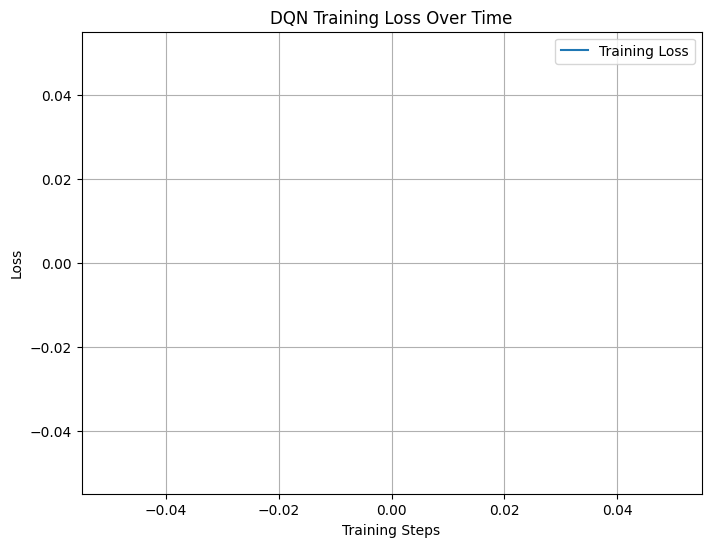

In [29]:
print(losses)
plt.figure(figsize=(8, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('DQN Training Loss Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
# Load the trained model
model = DQN.load("dqn_opamp")

# Reset the environment
state , _ = env.reset()

# Test the trained agent
for _ in range(1000):
    action, _ = model.predict(state, deterministic=True)
    state, reward, done, _, _ = env.step(action)
    print(f"Action: {action}, State: {state}, Reward: {reward}")
    if done:
        break

Action: 5, State: [1.0e+03 1.0e+03 9.5e-10], Reward: -7.9
Action: 5, State: [1.0000000e+03 1.0000000e+03 9.0249996e-10], Reward: -7.9
Action: 5, State: [1.0000000e+03 1.0000000e+03 8.5737495e-10], Reward: -7.9
Action: 5, State: [1.000000e+03 1.000000e+03 8.145062e-10], Reward: -7.9
Action: 5, State: [1.000000e+03 1.000000e+03 7.737809e-10], Reward: -7.9
Action: 5, State: [1.000000e+03 1.000000e+03 7.350918e-10], Reward: -7.9
Action: 5, State: [1.000000e+03 1.000000e+03 6.983372e-10], Reward: -7.9
Action: 5, State: [1.000000e+03 1.000000e+03 6.634204e-10], Reward: -7.9
Action: 5, State: [1.0000000e+03 1.0000000e+03 6.3024935e-10], Reward: -7.9
Action: 5, State: [1.000000e+03 1.000000e+03 5.987369e-10], Reward: -7.9
Action: 5, State: [1.0000000e+03 1.0000000e+03 5.6880006e-10], Reward: -7.9
Action: 5, State: [1.0000000e+03 1.0000000e+03 5.4036003e-10], Reward: -7.9
Action: 5, State: [1.0000000e+03 1.0000000e+03 5.1334204e-10], Reward: -7.9
Action: 5, State: [1.0000000e+03 1.0000000e+03 4